# Timing figures
This notebook is a test bed to plot some of the figures henry has requested, in preparation for beam-on data!

In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
import glob
import pickle as pkl

In [2]:
features = ['run', 'subrun', 'event', 'feb_mac5', 'feb_tagger', 'feb_flags',
       'feb_ts0', 'feb_ts1', 'feb_unixs', 'feb_adc', 'feb_coinc', 'cl_ts0',
       'cl_ts1', 'cl_unixs', 'cl_nhits', 'cl_tagger', 'cl_composition',
       'cl_channel_set', 'cl_adc_set', 'cl_has_sp', 'cl_sp_x', 'cl_sp_ex',
       'cl_sp_y', 'cl_sp_ey', 'cl_sp_z', 'cl_sp_ez', 'cl_sp_pe', 'cl_sp_ts0',
       'cl_sp_ets0', 'cl_sp_ts1', 'cl_sp_ets1', 'cl_sp_complete', 'tr_start_x',
       'tr_start_y', 'tr_start_z', 'tr_end_x', 'tr_end_y', 'tr_end_z',
      'tdc_channel', 'tdc_timestamp', 'tdc_offset',
       'tdc_name']

CRT_Wall_Dict = {
       "South": 1,
       "North": 2,
       "West": 3,
       "East": 4,
       "Bottom": 0,
       "Top Low": 5,
       "Top High": 6
       }

CRT_Wall_Arr = ["Bottom", "South", "North", "West", "East", "Top Low", "Top High"]

In [3]:
def list_matching_files(folder_path, pattern):
    search_pattern = os.path.join(folder_path, pattern)
    files = glob.glob(search_pattern)
    return [f for f in files if os.path.isfile(f)]

path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"
run="017985"
folder_path = path+run

# matching_files = list_matching_files(folder_path, "crtana_data_*")
matching_files = list_matching_files(folder_path, "crt_ana_*")

# Check how many files there are - memory gets upset if you try load too many
# Splitting the files into batches of 3 for now
batch_number = 0
batch_size = 3
# Theres probably a better way to loop this, but this is good enough for now!
print("Total batches = ", int(np.ceil(len(matching_files)/batch_size)))
matching_files = matching_files[batch_number*batch_size:(batch_number+1)*batch_size]



Total batches =  59


In [7]:
features = ["feb_ts0", "feb_ts1", "feb_flags", "tdc_timestamp", "tdc_name", "cl_has_sp", "cl_tagger", "cl_sp_ts0", "cl_sp_ts1", "cl_sp_x","cl_sp_y", "cl_sp_z"]

# Load the first file to get the columns
ttree = uproot.open(matching_files[0])
print("Loading ", matching_files[0], "...")
recodata = ttree['crtana/tree'].arrays(features, library='pd')
# Merge all the files into one dataframe
for file in matching_files[1:]:
    print("Loading ", file, "...")
    ttree = uproot.open(file)
    temp_recodata = ttree['crtana/tree'].arrays(features, library='pd')
    recodata = ak.concatenate([recodata, temp_recodata])
    ttree.close()



Loading  /exp/sbnd/data/users/jbateman/workdir/crt/run/017985/crt_ana_du.root ...
Loading  /exp/sbnd/data/users/jbateman/workdir/crt/run/017985/crt_ana_gb.root ...
Loading  /exp/sbnd/data/users/jbateman/workdir/crt/run/017985/crt_ana_fd.root ...


In [13]:
print("Keys:")
print(recodata.keys())
print("TDC entry names:")
print(recodata['tdc_name'][:1])

Keys:
['feb_ts0', 'feb_ts1', 'feb_flags', 'tdc_timestamp', 'tdc_name', 'cl_has_sp', 'cl_tagger', 'cl_sp_ts0', 'cl_sp_ts1', 'cl_sp_x', 'cl_sp_y', 'cl_sp_z']
TDC entry names:
[['crtt1', 'bes', 'etrig', 'ftrig', 'rwm']]


In [14]:
crtt1_index = np.where(recodata['tdc_name'][:1][0] == b'crtt1')[0][0]
etrig_index = np.where(recodata['tdc_name'][:1][0] == b'etrig')[0][0]
rwm_index = np.where(recodata['tdc_name'][:1][0] == b'rwm')[0][0]

print("crtt1 index = ", crtt1_index)
print("etrig index = ", etrig_index)
print("rwm index = ", rwm_index)

crtt1 index =  0
etrig index =  2
rwm index =  4


In [15]:
def flag_map(flag_arr, flag = 11):
    return [1 if x == flag else 0 for x in flag_arr]

In [19]:
ts0_arr = []
ts1_arr = []
flag_arr = []
tdc_etrig = []
trig_time = []

# trk_start_x = []
# trk_start_y = []
# trk_start_z = []

# trk_end_x = []
# trk_end_y = []
# trk_end_z = []

test_arr = [] 

ts0_arr = recodata['feb_ts0']
ts1_arr = recodata['feb_ts1']
# start_x = recodata['tr_start_x']
# start_y = recodata['tr_start_y']
# start_z = recodata['tr_start_z']

# end_x = recodata['tr_end_x']
# end_y = recodata['tr_end_y']
# end_z = recodata['tr_end_z']

flags = recodata["feb_flags"].values
tdc_time = recodata['tdc_timestamp'].values

for tdc, flag, ts0, ts1 in zip(tdc_time, flags, ts0_arr, ts1_arr):
    if len(tdc) == 5:
        tdc_offset = str(tdc[etrig_index]) # Get the TDC etrig
        tdc_offset = np.int64(tdc_offset[-9:]) # Get the last 9 digits for timing until t0 reset
        trig_time.extend(ts0 - tdc_offset)
        flag_arr.extend(flag)

trig_time = np.array(trig_time)/1e6 # convert from ns to ms


In [20]:
flag_11 = flag_map(flag_arr, 11)
flag_3 = flag_map(flag_arr, 3)

### Flag counts vs time

Can see the a dead time of ~20 microseconds!

In [21]:
def plot_flag_deadtime(trig_time, flag_dict, title=None, bins=100, time_range = (-1.55,-1.5)):
    fig = go.Figure()

    for flag, flag_arr in flag_dict.items():
        plt.hist(trig_time, weights=flag_arr, histtype='step', bins=bins, range=time_range, label=rf'Flag {flag}')
    
    plt.title(title)
    plt.xlabel('FEB TS0 - TDC ETRIG [ms]')
    plt.ylabel('Flag counts')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [ ]:
flag_dict = {11: flag_11, 3: flag_3}
plot_flag_deadtime(trig_time, flag_dict, title=f"Run {run}", time_range=(-2.,-1.9))

In [36]:
def save_as_pkl(trig_time, flag_11, flag_3, path, filename):
    data = {
        't0_etrig': trig_time,
        'flag_11': flag_11,
        'flag_3': flag_3
    }
    with open(os.path.join(path, filename), 'wb') as f:
        pkl.dump(data, f)

# Saving this as a pkl to merge with the other data!
path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"+run+"/"
filename = f"flag_t0_etrig_{batch_number}.pkl"
save_as_pkl(trig_time, flag_11, flag_3, path, filename)

### Top-hat plot

In [37]:
sp_features = ['cl_has_sp', 'cl_tagger', 'cl_sp_ts0', 'cl_sp_ts1', 'cl_sp_x', 'cl_sp_y', 'cl_sp_z'] # defining a reduced set of features to speed up processing

# Define a function to apply the boolean mask
def apply_mask(row):
    mask = row['cl_has_sp']  # only get entries with spacepoints
    return row.apply(lambda x: x[mask] if isinstance(x, ak.Array) else x)

def calculate_rel_ts0(ts0, rwm, etrig):
    delta_t = etrig - rwm
    return (ts0 + delta_t)/1e3

# Apply the mask to each row
print("filtering dataframe")
filtered_df = recodata[sp_features].apply(apply_mask, axis=1)
print("tagger")

filtering dataframe
tagger


In [45]:
relative_ts0 = []
relative_ts1 = []

wall_tag = []

filter_spx = []
filter_spy = []
filter_spz = []
filter_wall_tag = []

tagger_no_sp = filtered_df['cl_tagger']
# wall_tag.extend(list(ak.flatten(filtered_df['cl_tagger'])))
print("sp coords")
sp_x = filtered_df['cl_sp_x'].values
sp_y = filtered_df['cl_sp_y'].values
sp_z = filtered_df['cl_sp_z'].values
print("tsX")
sp_ts0 = filtered_df['cl_sp_ts0'].values
sp_ts1 = filtered_df['cl_sp_ts1'].values
print("tdc")
tdc_time = recodata['tdc_timestamp'].values
skip_counter = 0
for tdc, tagger, ts0, ts1, x, y, z in zip(tdc_time, tagger_no_sp, sp_ts0, sp_ts1, sp_x, sp_y, sp_z):
    if len(tdc) == 5:
        # ['crtt1' 'bes' 'etrig' 'ftrig' 'rwm']
        tdc_crt = np.int64(str(tdc[crtt1_index])[-12:])       # Get the last 12 digits for timing until CRT,
        tdc_rwm = np.int64(str(tdc[rwm_index])[-12:])       # Get the last 12 digits for timing until RWM, 
        tdc_etrig = np.int64(str(tdc[etrig_index])[-12:])     # otherwise leads to scalar subtract overflow

        delta_t = tdc_etrig - tdc_rwm
        relative_ts0.extend(ts0 + delta_t)
        relative_ts1.extend(ts1 + delta_t)
        filter_spx.extend(x)
        filter_spy.extend(y)
        filter_spz.extend(z)
        filter_wall_tag.extend(tagger)
        
        
    else:
        print("skipping event due to missing tdc data")
        skip_counter +=1
print(f"Skipped {skip_counter} events due to no TDC data")

filter_spx = np.array(filter_spx)
filter_spy = np.array(filter_spy)
filter_spz = np.array(filter_spz)

relative_ts0 = np.array(relative_ts0)/1e3 # convert from ns to μs
relative_ts1 = np.array(relative_ts1)/1e3 # convert from ns to μs
wall_tag = np.array(filter_wall_tag)

sp coords
tsX
tdc
Skipped 0 events due to no TDC data


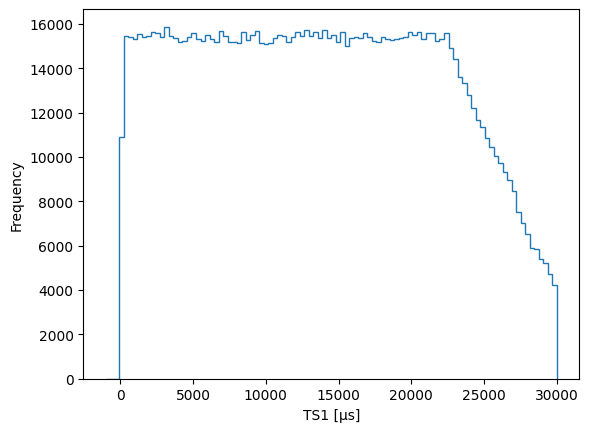

In [46]:
plt.hist(relative_ts1, bins=100, histtype='step', range=(-1000,30000))
plt.xlabel('TS1 [μs]')
plt.ylabel('Frequency')
plt.show()

In [47]:
def plot_sp_time(ts0, wall_tag, wall=None, title=None, bins=100, time_range = (-5,5), log_scale=False, wall_names=CRT_Wall_Arr):

    if wall is not None:
        print('wall')
        if type(wall) in (list, np.ndarray):
            print('arr')
            for wall_number in wall:
                plt.hist(ts0[wall_tag==wall_number]+1, histtype='step', bins=bins, range=time_range, label=wall_names[wall_number])
        elif type(wall) == int:
            print('int')
            plt.hist(ts0[wall_tag==wall]+1, histtype='step', bins=bins, range=time_range, label=wall_names[wall])
        else:
            print("Invalid wall type, plotting all walls")
            plt.hist(ts0+1, histtype='step', bins=bins, range=time_range)
        print('plotted')
    else:
        plt.hist(ts0+1, histtype='step', bins=bins, range=time_range)


    plt.title(title)
    plt.xlabel(rf'CRT Space Point Time [$\mu s$]')
    plt.ylabel('Wall counts')
    if log_scale: 
        plt.yscale('log')
    plt.legend()
    plt.show()

wall
int
plotted


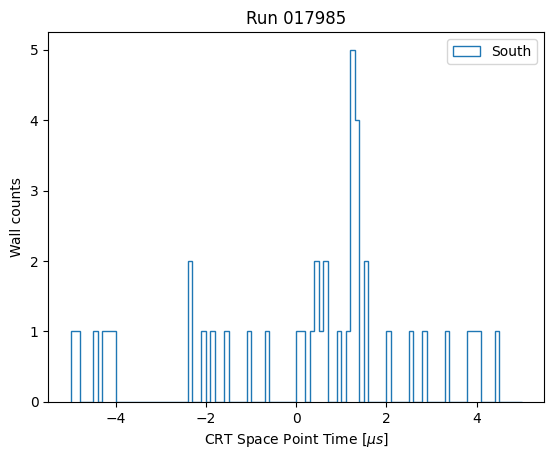

In [48]:
plot_sp_time(relative_ts0, wall_tag, wall=1, title=f"Run {run}", time_range=(-5,5), bins=100, log_scale=False)

Using the CRT spacepoint time, can I split the wall hits into two samples, in-window and out-of-window?

Then we can look at the spacepoints on the north/south walls and see if there is a concentration near to the centre of the beam! 

In [63]:
def plot_sp_coord_ratio(ts0, x, y, z, wall, run, plot_wall=1, interval_in = (-0.1, 1.7), interval_out = (-250, 250), offset=1, check_interval=False, bins=10, save=False):
    
    min_in, max_in = interval_in
    min_out, max_out = interval_out

    interval_in_window = (ts0 + offset > min_in) & (ts0 + offset < max_in) 
    interval_out_window = ((ts0 + offset < min_in) & (ts0 + offset > min_out)) | ((ts0 + offset > max_in) & (ts0 + offset < max_out))

    x_in = x[interval_in_window]
    y_in = y[interval_in_window]
    z_in = z[interval_in_window]

    wall_in = wall[interval_in_window]

    x_out = x[interval_out_window]
    y_out = y[interval_out_window]
    z_out = z[interval_out_window]

    wall_out = wall[interval_out_window]


    if check_interval:
        # Checking that we're splitting as we expect!
        # Slight overlap is due to binning
        time_range = (-5,5)
        bins_check = 50
        ts0_in = ts0[interval_in_window]
        ts0_out = ts0[interval_out_window]
        plt.hist(ts0_in + offset, histtype='step', bins=bins_check, range=time_range, label='In Window')
        plt.hist(ts0_out + offset, histtype='step', bins=bins_check, range=time_range, label='Out Window')
        plt.legend()
        plt.xlabel('CRT Space Point Time [μs]')
        plt.ylabel('Counts')
        plt.xlim(-5,5)
        plt.show()

    # North/South walls
    if plot_wall == 1 or plot_wall == 2:
        print('north/south')
        x_axis_in = x_in[wall_in == plot_wall]
        y_axis_in = y_in[wall_in == plot_wall]
        x_axis_out = x_out[wall_out == plot_wall]
        y_axis_out = y_out[wall_out == plot_wall]
        x_label = 'X [cm]'
        y_label = 'Y [cm]'

    # Bottom/top walls
    if plot_wall == 0 or plot_wall == 5 or plot_wall == 6:
        print('bottom/top')
        x_axis_in = z_in[wall_in == plot_wall]
        y_axis_in = x_in[wall_in == plot_wall]
        x_axis_out = z_out[wall_out == plot_wall]
        y_axis_out = x_out[wall_out == plot_wall]
        x_label = 'Z [cm]'
        y_label = 'X [cm]'

    # East/West walls
    if plot_wall == 3 or plot_wall == 4:
        print('east/west')
        x_axis_in = z_in[wall_in == plot_wall]
        y_axis_in = y_in[wall_in == plot_wall]
        x_axis_out = z_out[wall_out == plot_wall]
        y_axis_out = y_out[wall_out == plot_wall]
        x_label = 'Z [cm]'
        y_label = 'Y [cm]'
    
    hist_out, xedges, yedges = np.histogram2d(x_axis_out, y_axis_out, bins=bins)
    exposure_out = max_out - min_out - (max_in - min_in)
    hist_out = hist_out/exposure_out

    hist_in, xedges, yedges = np.histogram2d(x_axis_in, y_axis_in, bins=(xedges, yedges))
    exposure_in = max_in - min_in
    hist_in = hist_in/exposure_in
    
    ratio_hist = hist_in/hist_out

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    fig.suptitle(f'{CRT_Wall_Arr[plot_wall]} CRT Space Point Distribution (scaled by exposure time) - Run {run}')
    im1 = ax[0].imshow(hist_in.T, extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]], origin='lower', cmap='viridis')
    ax[0].set_title('In-Window ({} — {} μs)'.format(min_in, max_in))
    ax[0].set_xlabel(x_label)  
    ax[0].set_ylabel(y_label)

    im2 = ax[1].imshow(hist_out.T, extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]], origin='lower', cmap='viridis')
    ax[1].set_title('Out-of-Window ({} —  {} μs)'.format(min_out, max_out))
    ax[1].set_xlabel(x_label)
    ax[1].set_ylabel(y_label)

    im3 = ax[2].imshow(ratio_hist.T, extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]], origin='lower', cmap='viridis')
    ax[2].set_title('In/Out Ratio')
    ax[2].set_xlabel(x_label)
    ax[2].set_ylabel(y_label)

    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    fig.colorbar(im3, ax=ax[2])
    if save:
        # fig.save(rf'./figures/space_point_{CRT_Wall_Arr[plot_wall]}.png')
        plt.savefig(rf'./figures/space_point_{CRT_Wall_Arr[plot_wall]}.png')
    plt.show()


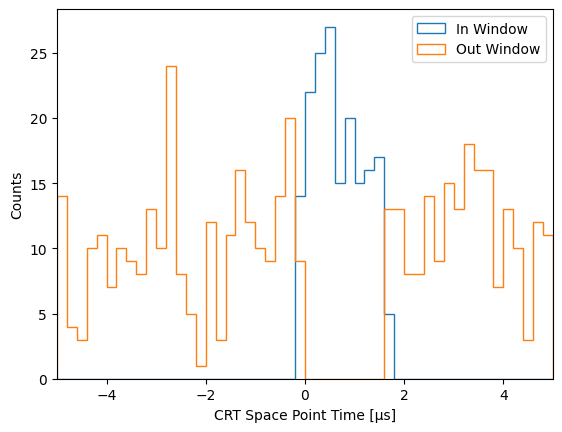

north/south


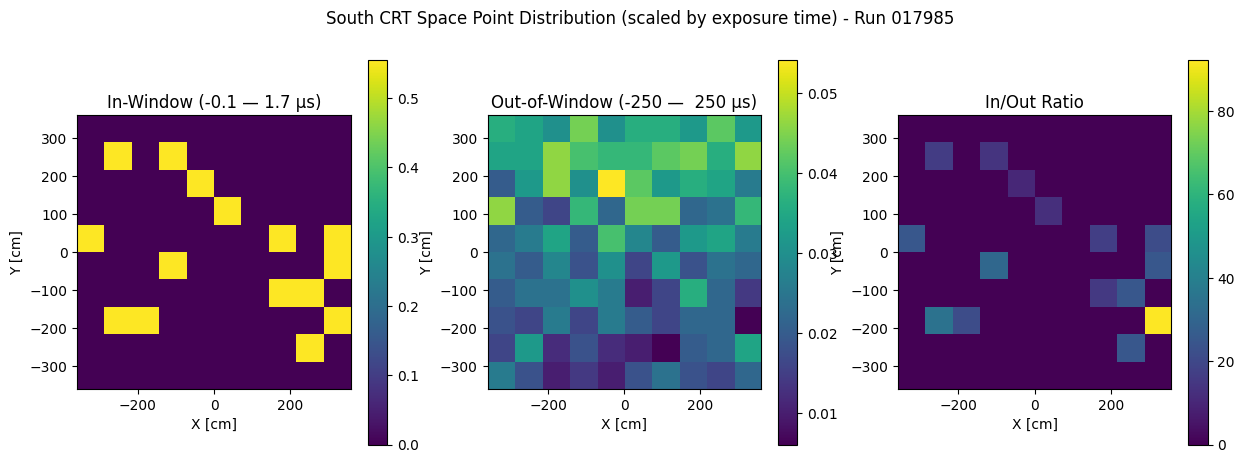

In [67]:
crt_offset = 0.24
plot_sp_coord_ratio(relative_ts0, filter_spx, filter_spy, filter_spz, wall_tag, run, plot_wall=1, interval_in=(-0.1, 1.7), interval_out=(-250, 250), offset=crt_offset, check_interval=True, bins=10)

In [68]:
def save_as_pkl(relative_ts0, wall_tag, filter_spx, filter_spy, filter_spz, path, filename):
    data = {
        'relative_ts0': relative_ts0,
        'wall_tag': wall_tag,
        'filter_spx': filter_spx,
        'filter_spy': filter_spy,
        'filter_spz': filter_spz
    }
    with open(os.path.join(path, filename), 'wb') as f:
        pkl.dump(data, f)

# Saving this to a pkl to combine with other runs
path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"+run+"/"
filename = f"sp_timing_{batch_number}.pkl"
save_as_pkl(relative_ts0, wall_tag, filter_spx, filter_spy, filter_spz, path, filename)

# Combined run figures
For a list of runs that have been process above, the output csv files are loaded, merged and the combined figures are plotted

In [182]:
list_of_runs = [17985] #[13688, 13689, 13690, 13693, 13758]
path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"
    # run="013688"
    # folder_path = path+run
n_batches = []

filename = "crt_ana_*" # "crtana_data_*"

for run in list_of_runs:

    folder_path = path + "0" + str(run) + "/"
    matching_files = list_matching_files(folder_path,filename)
    n_batches.append(int(np.ceil(len(matching_files)/batch_size)))


In [183]:
path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"
filename_deadtime = 'flag_t0_etrig_' # 'flag_t0_etrig.pkl'
filename_sp = 'sp_timing_'

arr_flag_t0_etrig = np.empty((0, 3))
arr_sp_timing = np.empty((0, 5))

for i, run in enumerate(list_of_runs):
    for batch in range(n_batches[i]):
        batch_deadtime = filename_deadtime + str(batch) + '.pkl'
        batch_sp = filename_sp + str(batch) + '.pkl'
        
        with open(path + "0" + str(run) + "/" + batch_deadtime, 'rb') as f:
            data_deadtime = pkl.load(f)
            arr_flag_t0_etrig = np.vstack([arr_flag_t0_etrig, np.column_stack((data_deadtime['t0_etrig'], data_deadtime['flag_11'], data_deadtime['flag_3']))])
        
        with open(path + "0" + str(run) + "/" + batch_sp, 'rb') as f:
            data_sp = pkl.load(f)
            arr_sp_timing = np.vstack([arr_sp_timing, np.column_stack((data_sp['relative_ts0'], data_sp['wall_tag'], data_sp['filter_spx'], data_sp['filter_spy'], data_sp['filter_spz']))])

ts0_etrig = arr_flag_t0_etrig[:, 0]
flag_11 = arr_flag_t0_etrig[:, 1]
flag_3 = arr_flag_t0_etrig[:, 2]

ts0_rwm = arr_sp_timing[:, 0]
wall = arr_sp_timing[:, 1]
spx = arr_sp_timing[:, 2]
spy = arr_sp_timing[:, 3]
spz = arr_sp_timing[:, 4]

FileNotFoundError: [Errno 2] No such file or directory: '/exp/sbnd/data/users/jbateman/workdir/crt/run/017985/flag_t0_etrig_1.pkl'

In [185]:
ts0_etrig = arr_flag_t0_etrig[:, 0]
flag_11 = arr_flag_t0_etrig[:, 1]
flag_3 = arr_flag_t0_etrig[:, 2]

ts0_rwm = arr_sp_timing[:, 0]
wall = arr_sp_timing[:, 1]
spx = arr_sp_timing[:, 2]
spy = arr_sp_timing[:, 3]
spz = arr_sp_timing[:, 4]

## Dead time

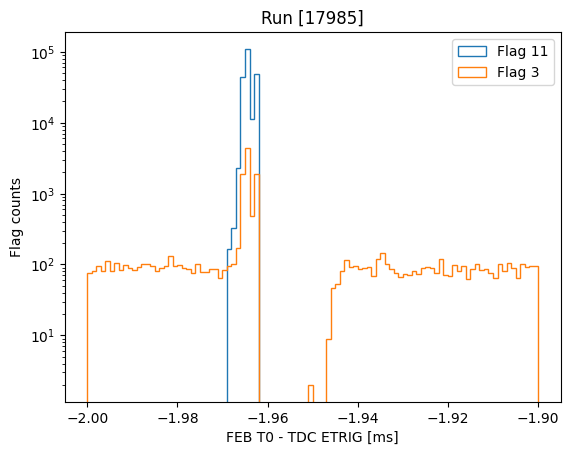

In [187]:
time_range = (-2,-1.9)
plot_flag_deadtime(ts0_etrig, {11: flag_11, 3: flag_3}, title=f"Run {list_of_runs}", time_range=time_range)


## Top-hat

/tmp/ipykernel_811665/838413478.py:25: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



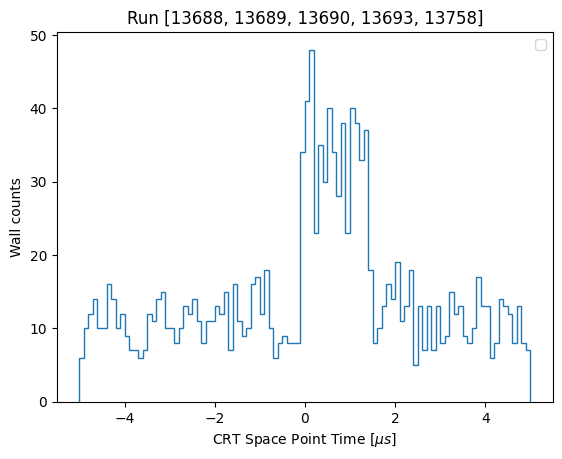

In [69]:
plot_sp_time(ts0_rwm, wall, title=f"Run {list_of_runs}", bins=100)

wall
arr
plotted


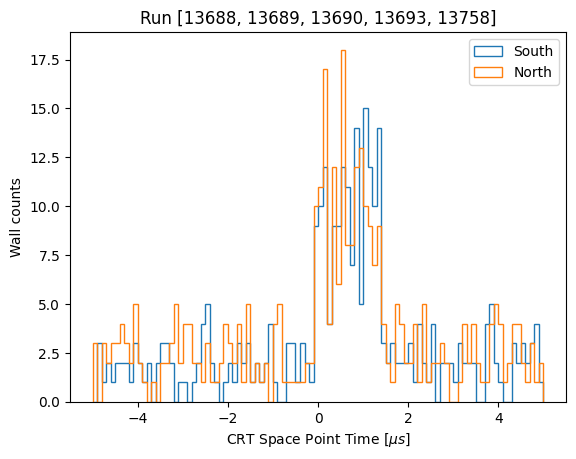

In [70]:
plot_sp_time(ts0_rwm, wall, wall=[1,2], title=f"Run {list_of_runs}", bins=100)

## Space-point distribution

1
north/south


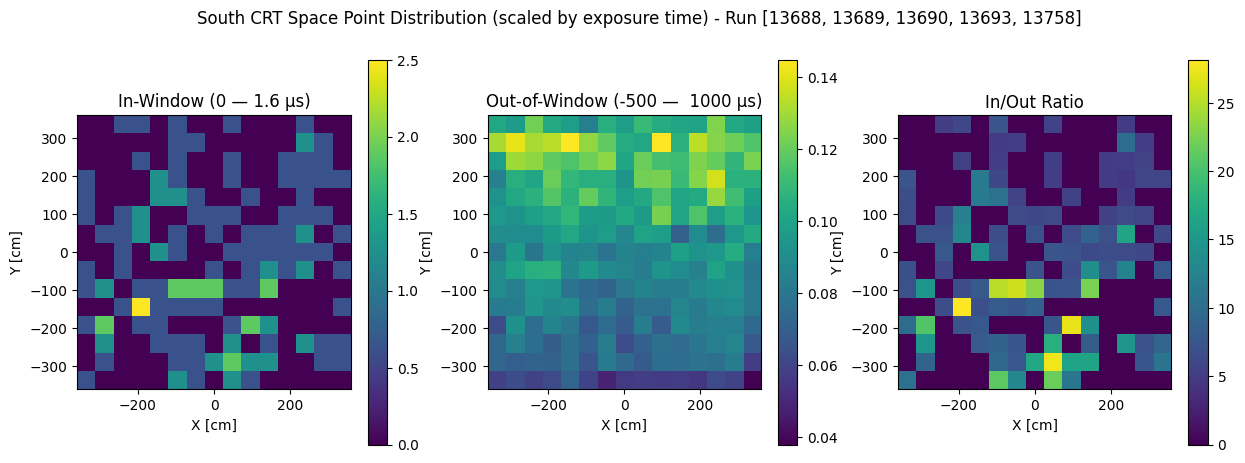

2
north/south


/tmp/ipykernel_811665/2378616401.py:74: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_811665/2378616401.py:74: RuntimeWarning:

invalid value encountered in divide



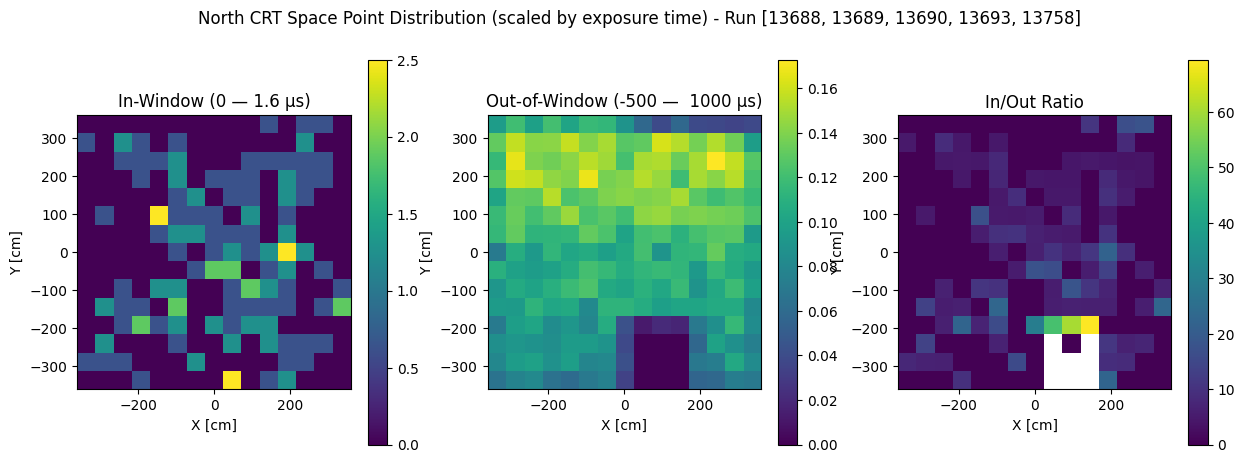

3
east/west


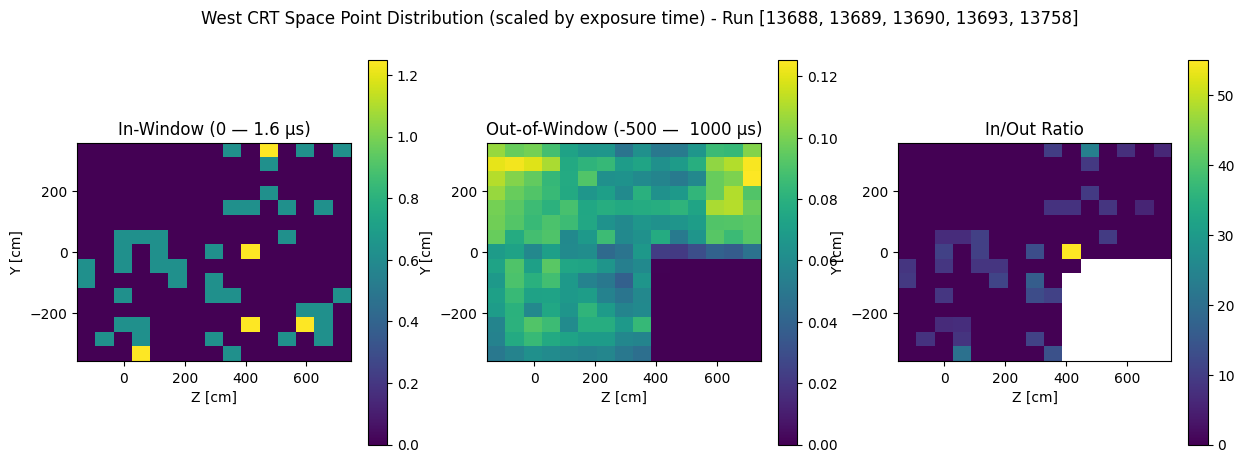

4
east/west


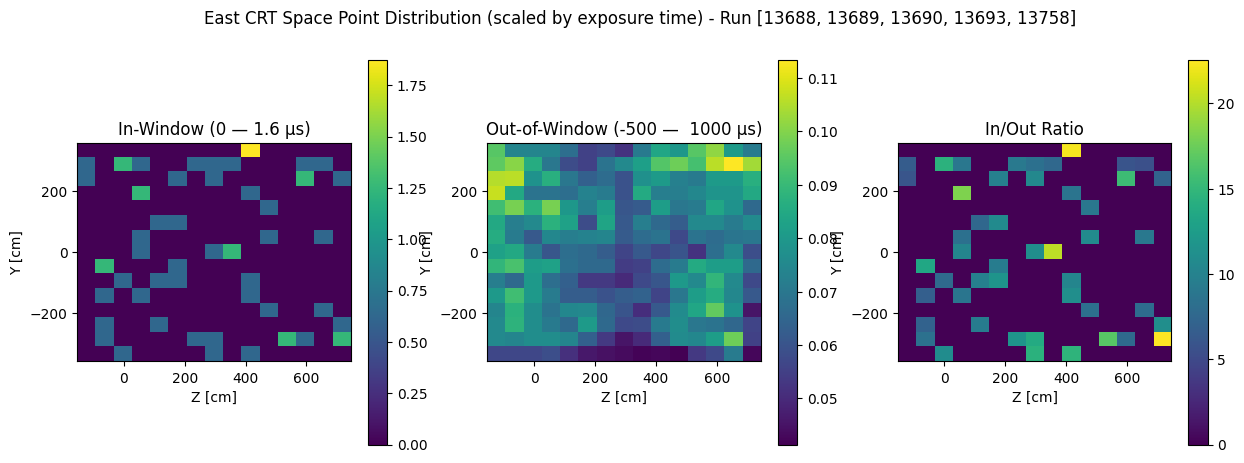

0
bottom/top


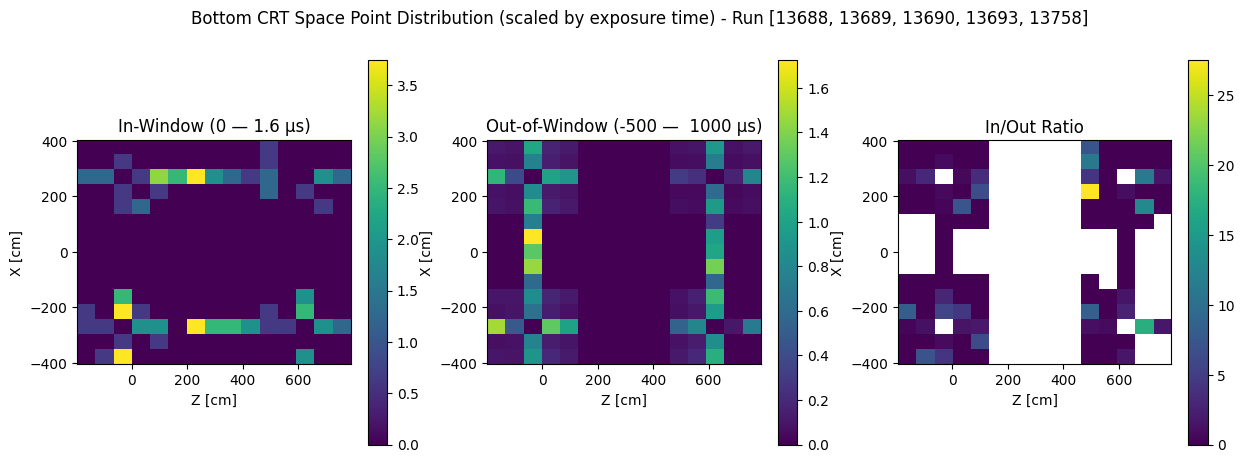

5
bottom/top


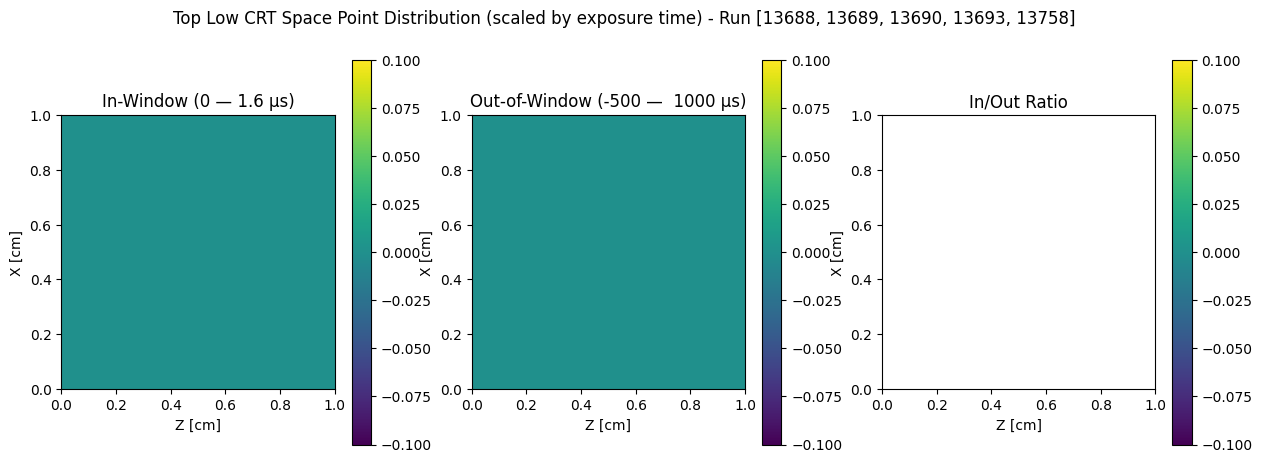

6
bottom/top


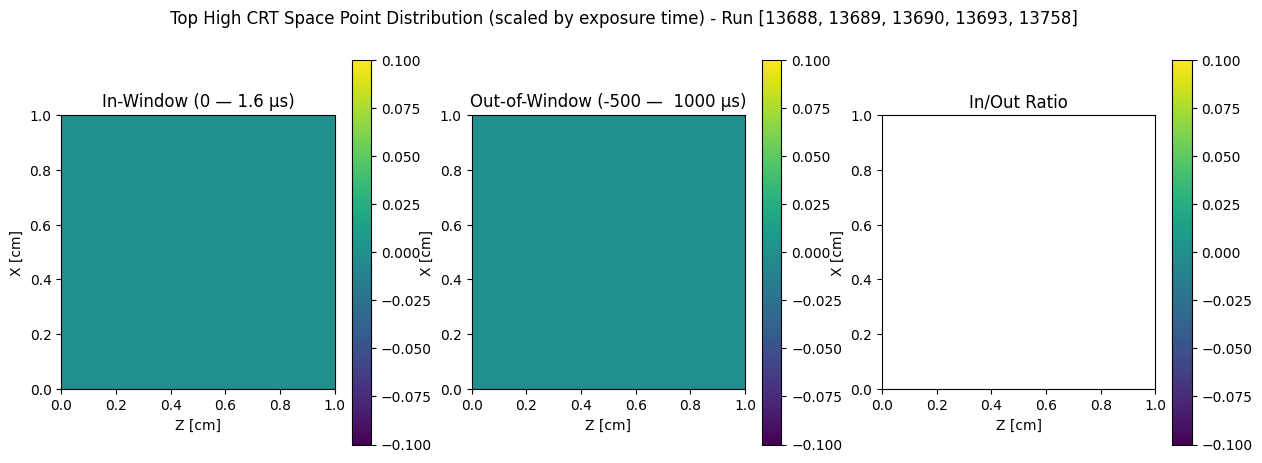

In [71]:
for wall_id in (list(CRT_Wall_Dict.values())):
    print(wall_id)
    plot_sp_coord_ratio(ts0_rwm, spx, spy, spz, wall, list_of_runs, plot_wall=wall_id, interval_in=(0, 1.6), interval_out=(-500, 1000), check_interval=False, bins=15, save=True)